In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
#import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from matplotlib import pyplot as plt
import struct

In [2]:
def readAppr(path):
    f = gzip.open(path, 'rt')
    for l in f:
        u,i,ts = l.strip().split(' ')
        yield u,i,ts

def readOwners(path):
    f = gzip.open(path, 'rt')
    for l in f:
        u,i = l.strip().split(' ')
        yield u,i
        
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

In [32]:
interactions = []
for l in readAppr("Behance_appreciate_1M.gz"):
    interactions.append(l)
print(interactions[0]) # interactions is : user_id, item_id, timestamp
creations = []
for l in readOwners("Behance_Item_to_Owners.gz"):
    creations.append(l)

('276633', '01588231', '1307583271')


In [4]:
def readImageFeatures(path):
    f = open(path, 'rb')
    while True:
        itemId = f.read(8)
        if itemId == '': break
        feature = struct.unpack('f'*4096, f.read(4*4096))
        print(itemId, feature)
        break
    return feature
path = 'Behance_Image_Features.b'
ff = readImageFeatures(path)


b'01955333' (0.0, 2.547630548477173, 0.0, 2.1048479080200195, 0.0, 1.4637823104858398, 0.0, 0.0, 0.0, 0.7271959781646729, 0.0, 0.925341010093689, 0.0, 0.0, 2.7910685539245605, 0.0, 3.1945674419403076, 0.0, 0.0, 0.0, 0.5582950711250305, 0.0, 0.0, 0.4864542782306671, 0.8252065777778625, 0.0, 4.805290699005127, 0.0, 0.0, 0.0, 1.653975009918213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08063966035842896, 0.0, 4.080291271209717, 0.0, 0.0, 0.0, 0.382120817899704, 0.0, 0.0, 3.3514671325683594, 0.0, 0.0, 1.335052251815796, 3.8390321731567383, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.463691234588623, 1.7831394672393799, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4732742309570312, 0.3781372308731079, 0.7882523536682129, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.672399044036865, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6109278202056885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9933780431747437, 0.0, 0.0, 0.0, 1.4351845979690552, 1.6859850883483887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1043719053268433, 0.0, 0.0, 

In [5]:
ff_np = np.array(ff)
if type(ff_np) is np.ndarray:
    print('yes')
print(ff_np)

ff_np.shape
new = np.reshape(ff_np, (-1, 64))
new.shape

yes
[0.         2.54763055 0.         ... 0.         0.         0.36156493]


(64, 64)

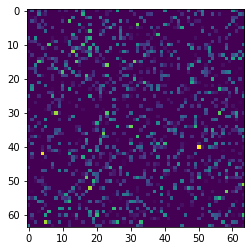

In [6]:
plt.imshow(new, interpolation='nearest')

## Exploratory Data Analysis

In [7]:
#size of dataset
print(len(creations))
print(len(interactions))

186560
1000000


In [8]:
imgsperUser = defaultdict(list)
userperImgs  = defaultdict(list)
createdperUser = defaultdict(list)
usersperCreation = defaultdict(list)
for u,i,_ in interactions:
    imgsperUser[u].append(i)
    userperImgs[i].append(u)

for c,u in creations:
    createdperUser[u].append(c)
    usersperCreation[c].append(u)


In [9]:
x = len(imgsperUser) #no of users
y = len(userperImgs) #no of images
z = len(createdperUser) #no. of creators
r = len(usersperCreation) # no of creations
x,y,z,r

(63497, 178788, 51487, 178788)

In [10]:
all_images = set()
for j in list(userperImgs.keys()):
    all_images.add(j)
print(len(all_images))
#print(all_images)


178788


In [11]:
all_images_with_creators = set()
for j in list(usersperCreation.keys()):
    all_images_with_creators.add(j)
print(len(all_images_with_creators))
#print(all_images_with_creators)

178788


In [12]:
all_images_with_no_creators = [e for e in all_images if e not in all_images_with_creators]
print(len(all_images_with_no_creators))
print(len(all_images.intersection(all_images_with_creators)))

0
178788


In [13]:
images_with_gt_1 = [c for c,u in usersperCreation.items() if len(u)>1 ]

In [14]:
len(images_with_gt_1)/r # % images with more than 1 creator

0.03330201132067029

In [16]:
max_creators_for_one_image = 0 #stores the max number of creators for an image across all images
image_with_max_creators = "NONE"

for c,u in usersperCreation.items():
    if(len(u) > max_creators_for_one_image):
        max_creators_for_one_image = len(u)
        image_with_max_creators = c
print(image_with_max_creators, max_creators_for_one_image)

02138210 29


In [17]:
print(images_with_gt_1[122])
usersperCreation[images_with_gt_1[122]]

00100435


['1691295', '1567008']

In [18]:
createdperUser['00045353']

[]

In [19]:
imgCountAll = defaultdict(int)
totalliked = 0

for user,img,_ in interactions:
    imgCountAll[img] += 1
    totalliked+= 1

mostPopular = [(imgCountAll[x], x) for x in imgCountAll]
mostPopular.sort()
mostPopular.reverse()
print(totalliked)


1000000


In [20]:
return2 = set()
count = 0
threshold = 0.75
for imgCount, img in mostPopular:
    count += imgCount
    return2.add(img)
    if count > totalliked*threshold:
        break

In [21]:
def Jaccard(s1, s2):
    if not isinstance(s1,set):
        s1 = set(s1)
    if not isinstance(s2,set):
        s2 = set(s2)
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def predictRead(user, img):
    Jsimilarities = []
    for d in imgsperUser[user]:
    #d is img user has liked in training
        if d == img: continue
        Jsimilarities.append(Jaccard(userperImgs[img],userperImgs[d]))
    if Jsimilarities and max(Jsimilarities)> 0.003 or img in return2:
        return 1
    return 0
  # mx = 0
  # if Jsimilarities:
  #     mx = max(Jsimilarities)
  # elif len(Jsimilarities) == 0:
  #   mx = 0
  # if img in return2:
  #     return 1 + mx
  # return mx

In [33]:
likedValid = interactions[990000:]
likedValid = [i + (1,) for i in likedValid]
print(likedValid[0]) # 1 says that the book has been read by the user

imgsperUserVal = defaultdict(list)
for u,img,_,_ in likedValid:
    imgsperUserVal[u].append(img)

len(likedValid)

('1290046', '00314787', '1321118663', 1)


10000

In [23]:
all_books = set(userperImgs.keys())
val_pairs = set()
for user in imgsperUserVal.keys():
    no_books_read = len(imgsperUserVal[user])
    books_not_read = list(all_books.difference(set(imgsperUser[user])))
    for _ in range(no_books_read):
        book = random.choice(books_not_read)
        if (user,book, 'NA', 0) not in val_pairs:
            book = book
        else:
            while (user,book, 'NA', 0) in val_pairs:
                book = random.choice(books_not_read)
        val_pairs.add((user,book,'NA',0))
        likedValid.append((user,book,'NA',0)) 

len(likedValid)

20000

In [36]:
#print(likedValid)

In [28]:
# gives a list of all creators of all the images the user likes
def give_creator_list(user):
    creators = set()
    #print(user)
    for d in imgsperUser[user]:
        #print(d)
        #print(len(usersperCreation[d]))
        for c in usersperCreation[d]:
            #print("Creator of", d,c)
            creators.add(c)
    return creators

In [29]:
print(give_creator_list('957591'))

{'2335443', '3220123'}


In [37]:
def predictRead_with_creators(user, img):
    Jsimilarities = []
    for d in imgsperUser[user]:
    #d is img user has liked in training
        if d == img: continue
        Jsimilarities.append(Jaccard(userperImgs[img],userperImgs[d]))
    if Jsimilarities and max(Jsimilarities)> 0.003 or img in return2:
        return 1
    else:
        creators_of_user_liked_images = give_creator_list(user)
        creators_of_img = usersperCreation[img]
        creators_of_user_liked_images_set = set()
        creators_of_img_set = set()
        for i in creators_of_user_liked_images:
            creators_of_user_liked_images_set.add(i)
        for i in creators_of_img:
            creators_of_img_set.add(i)
        intersection_of_creators = creators_of_user_liked_images_set.intersection(creators_of_img_set)
        print("intersection_of_creators", intersection_of_creators)
        if intersection_of_creators == "":
            return 1
    return 0

In [38]:
preds = [predictRead_with_creators(u,b) for u,b,_,_ in likedValid]
correct = sum([likedValid[i][3]  == preds[i] for i in range(len(likedValid))])
y = [x for _,_,_,x in likedValid]
acc4 = correct/len(preds)
acc4 

intersection_of_creators {'2335443', '3220123'}
intersection_of_creators {'1852282'}
intersection_of_creators {'2277928'}
intersection_of_creators {'2072774'}
intersection_of_creators {'2469865'}
intersection_of_creators {'3423194'}
intersection_of_creators {'2062469'}
intersection_of_creators {'3690533'}
intersection_of_creators {'1148759'}
intersection_of_creators {'2819030'}
intersection_of_creators {'316785'}
intersection_of_creators {'1075213'}
intersection_of_creators {'2819167'}
intersection_of_creators {'3160899', '3802618', '810704'}
intersection_of_creators {'264236'}
intersection_of_creators {'2092652'}
intersection_of_creators {'1993747'}
intersection_of_creators {'141995'}
intersection_of_creators {'2049700'}
intersection_of_creators {'2804070'}
intersection_of_creators {'2623817'}
intersection_of_creators {'3563632'}
intersection_of_creators {'2304907'}
intersection_of_creators {'830997'}
intersection_of_creators {'1600941'}
intersection_of_creators {'129969', '1267681', 

0.9943

In [35]:
#for i in range(len(likedValid)):
#    if (likedValid[i][3] == 1 and preds[i] ==0):
#        print(likedValid[i][0],likedValid[i][1])
#        print(give_creator_list(likedValid[i][0]), usersperCreation[likedValid[i][1]])

957591 02290382
{'2335443', '3220123'} ['3220123', '2335443']
2292514 02489927
{'1852282'} ['1852282']
477783 01931679
{'2277928'} ['2277928']
3569581 02490541
{'2072774'} ['2072774']
3812841 02485873
{'2469865'} ['2469865']
3030674 02490001
{'3423194'} ['3423194']
2614282 02253564
{'2062469'} ['2062469']
3285542 02491273
{'3690533'} ['3690533']
1880281 02431635
{'1148759'} ['1148759']
1138899 02255260
{'2819030'} ['2819030']
1562457 02067904
{'316785'} ['316785']
854747 00882913
{'1075213'} ['1075213']
557030 02455847
{'2819167'} ['2819167']
455022 02481853
{'3160899', '3802618', '810704'} ['810704', '3160899', '3802618']
561411 01304707
{'264236'} ['264236']
3490724 00146134
{'2092652'} ['2092652']
1696349 02480175
{'1993747'} ['1993747']
3617631 02492301
{'141995'} ['141995']
3646885 02482127
{'2049700'} ['2049700']
2093600 02492385
{'2804070'} ['2804070']
1205861 02490073
{'2623817', '2512399'} ['2623817']
361007 02492589
{'3563632'} ['3563632']
1680505 01932003
{'2304907'} ['23049